In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from bard_VAE import Autoencoder
from custom_dataset import CustomDataset
from torchvision.transforms.functional import normalize
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder().to(device)


# ## Data Parallelism
# if torch.cuda.is_available() and torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs for Data Parallelism!")
#     autoencoder = nn.DataParallel(Autoencoder().to(device))
# else:
#     autoencoder = Autoencoder().to(device)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))

])
batch_size = 1024
train_dataset = CustomDataset(data_path='/mayo_atlas/home/m296984/MAIN_CHAIN_LIVER_RESULTS/train_16x16_patches', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [3]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

Epoch [1/10], Batch [0/915], Loss: 0.2198
Epoch [1/10], Batch [250/915], Loss: 0.1184
Epoch [1/10], Batch [500/915], Loss: 0.0931
Epoch [1/10], Batch [750/915], Loss: 0.0883


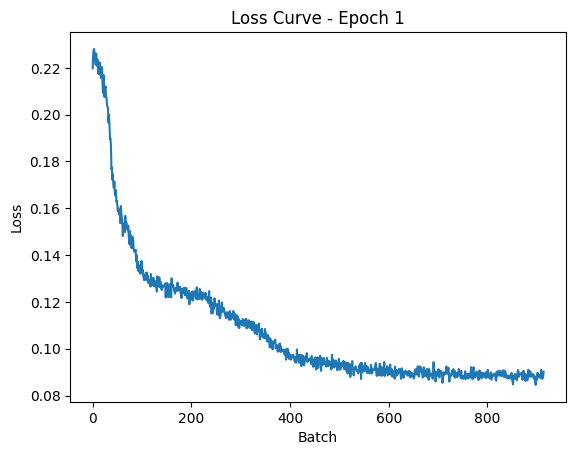

Epoch [2/10], Batch [0/915], Loss: 0.0890
Epoch [2/10], Batch [250/915], Loss: 0.0874
Epoch [2/10], Batch [500/915], Loss: 0.0878
Epoch [2/10], Batch [750/915], Loss: 0.0850


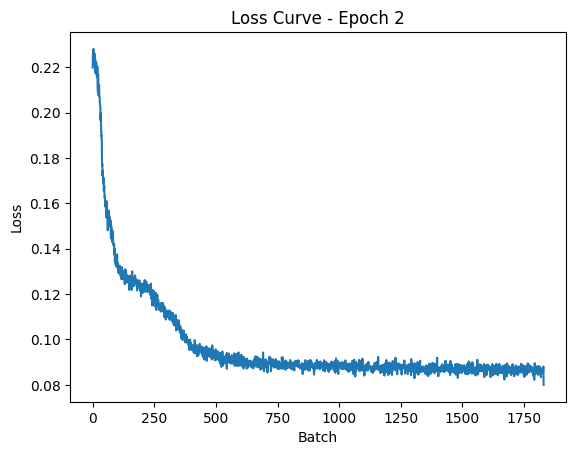

Epoch [3/10], Batch [0/915], Loss: 0.0885
Epoch [3/10], Batch [250/915], Loss: 0.0857
Epoch [3/10], Batch [500/915], Loss: 0.0841
Epoch [3/10], Batch [750/915], Loss: 0.0847


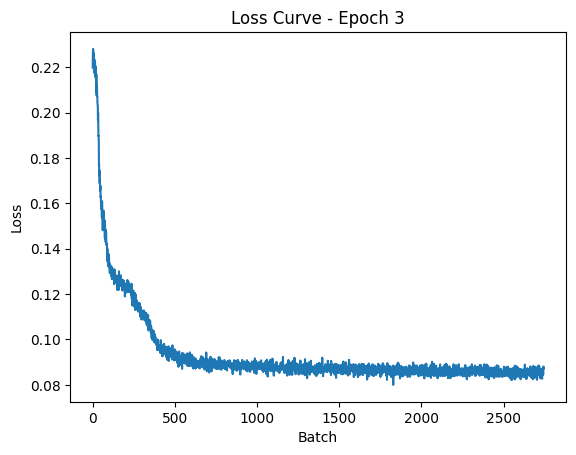

Epoch [4/10], Batch [0/915], Loss: 0.0868
Epoch [4/10], Batch [250/915], Loss: 0.0813


In [4]:
# Training loop
num_epochs = 10
losses = []  # List to store loss values

for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        
        # Forward pass
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        # Store loss value
        losses.append(loss.item())
        
        if batch_idx % 250 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
            
            # Visualize reconstructed images
            with torch.no_grad():
                autoencoder.eval()
                test_images, _ = next(iter(train_loader))
                test_images = test_images.to(device)
                reconstructed = autoencoder(test_images)
                autoencoder.train()
                
                # Plot original images
                plt.figure(figsize=(10, 4))
                for i in range(5):
                    plt.subplot(2, 5, i + 1)
                    plt.imshow((test_images[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)
                    plt.title("Original")
                    plt.axis('off')

                    plt.subplot(2, 5, i + 6)
                    plt.imshow((reconstructed[i].permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5)
                    plt.title("Reconstructed")
                    plt.axis('off')
                plt.savefig(f"/home/m296984/MAIN_CHAIN/NEW_VAE_IMAGES/epoch_{epoch}_visualization_batch_{batch_idx}.png")
                plt.close()  # Close the figure to release memory
                
    torch.save(autoencoder.state_dict(), f"/home/m296984/MAIN_CHAIN/NEW_VAE_MODELS/autoencoder_epoch_{epoch}.pt")
    # Plot loss curve
    plt.plot(losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve - Epoch {epoch+1}")
    plt.show()